In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader

from network import CNN
from load_data import ToTensor, ADdataset
from extractor import feature_extractor
from tools import get_gradcam
from label_and_evaluate import get_argmax_label, numbered_labels, cost_matrix, evaluate_assignment
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker
from skimage import measure
from skimage.measure import label
from skimage.morphology import remove_small_objects
from scipy.ndimage import median_filter
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance

In [2]:
#load data
cv = "/Users/ophelia/Desktop/Brain2+5SamplesCV/cv10_1002_Test2.npy"
path = "/Users/ophelia/Desktop/TrainingDataApril2022/BrainSamples_032922/"

AD_DataSet=ADdataset(path=path,cv=cv,transform=ToTensor())
AD_DataLoader=DataLoader(AD_DataSet, batch_size=1,shuffle=False)

In [3]:
#load a trained cnn model
network = CNN(3, 2, 8, 9)
network.load_state_dict(torch.load('/Users/ophelia/Desktop/Brain2+5SamplesCV/checkpoint_20.pth'))
network.eval()
network.zero_grad()

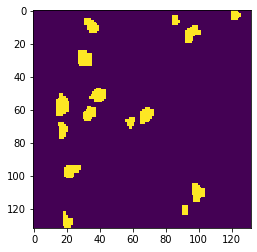

In [4]:
#load a sample image
a = 0
for i in AD_DataLoader:
    a += 1
    if a == 100:
        I = i['image']
        c = i['label']
        break
plt.imshow(c[0]/255)

In [5]:
#get activation and gradient for both classes
extractor = feature_extractor(network, network.dcc1[1])
act0, grad0, pred = extractor.get_features(I, index=0)
act1, grad1, pred = extractor.get_features(I, index=1)
cam0, cam1 = get_gradcam(act0, grad0, act1, grad1)

/Users/ophelia/Desktop/research/gradcam-seg/extractor.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = m(self.model(I))


Text(0.5, 1.0, 'Class 1 (Tau)')

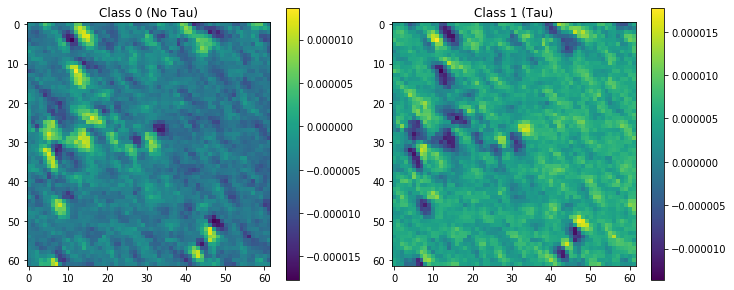

In [6]:
#imshow gradcam
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
h = ax1[0].imshow(cam0)
plt.colorbar(h, ax=ax1[0])
ax1[0].set_title('Class 0 (No Tau)')
h1 = ax1[1].imshow(cam1)
plt.colorbar(h1, ax=ax1[1])
ax1[1].set_title('Class 1 (Tau)')

/Users/ophelia/Desktop/research/gradcam-seg/label_and_evaluate.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  argmax_label = torch.tensor(argmax_label, dtype=torch.long)
/Users/ophelia/Desktop/research/gradcam-seg/label_and_evaluate.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  argmax_label = torch.where(resampledgradcam0==-1, resampledgradcam0, torch.tensor(argmax_label, dtype=torch.long))


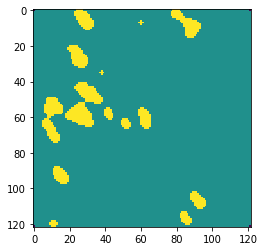

In [7]:
#get argmax labels that is denoised with morphological opening
argmax_label = get_argmax_label(cam0, cam1, 3)
argmax_label = median_filter(argmax_label, size=(3,3)) #apply an median filter to smooth out argmax labels
argmax_label = argmax_label[5:-5, 5:-5]#
plt.imshow(argmax_label)

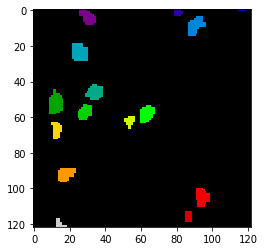

In [8]:
#get manual labels and crop
manual_label = label(c[0][5:-5, 5:-5])
plt.imshow(manual_label, cmap=plt.cm.nipy_spectral)

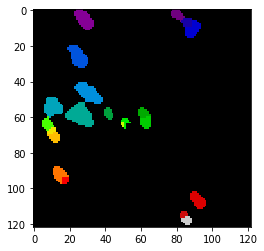

In [9]:
#generated numbered labels with watershed segmentation and remove small regions
numbered_argmax_label = numbered_labels(np.array(argmax_label))
numbered_argmax_label = remove_small_objects(numbered_argmax_label, 15)
numbered_argmax_label = numbered_labels(numbered_argmax_label)

plt.imshow(numbered_argmax_label, cmap=plt.cm.nipy_spectral)

In [10]:
#get centroids of labeled regions
argmax_regions = measure.regionprops(numbered_argmax_label)
argmax_centroids = [i.centroid for i in argmax_regions]

manual_regions = measure.regionprops(manual_label)
manual_centroids = [i.centroid for i in manual_regions]

In [11]:
#compute cost matrix and optimal pairing between label sets
cost_mat = cost_matrix(manual_centroids, argmax_centroids)
row_ind, col_ind = linear_sum_assignment(cost_mat)

Text(0.5, 1.0, 'Argmax Label')

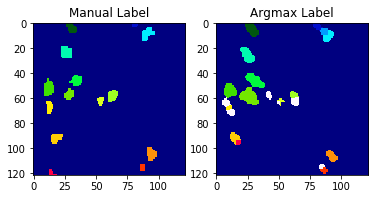

In [12]:
#visualize assignment by reassigning labels

max_label = np.max(col_ind)
paired_label = np.array(numbered_argmax_label)

for i in range(len(np.unique(numbered_argmax_label))):
    if i != 0 and i-1 not in col_ind:
        paired_label[numbered_argmax_label==i] = max_label + 2

for i in range(len(row_ind)):
    true_idx = row_ind[i] + 1
    labels_idx = col_ind[i] + 1
    paired_label[numbered_argmax_label==labels_idx] = true_idx
    
f, a = plt.subplots(1, 2)
a[0].imshow(manual_label, cmap=plt.cm.gist_ncar, vmin=0, vmax=20)
a[0].set_title('Manual Label')
a[1].imshow(paired_label, cmap=plt.cm.gist_ncar, vmin=0, vmax=20)
a[1].set_title('Argmax Label')

In [13]:
#evaluate assignment
TP, FP, FN = evaluate_assignment(manual_label, numbered_argmax_label, row_ind, col_ind)

manual label: 0 , area: 57 , argmax label: 1 , area: 86  Overlap: 42
manual label: 1 , area: 18 , argmax label: 0 , area: 36  Overlap: 16
manual label: 2 , area: 4 , argmax label: 2 , area: 27  Overlap: 0
manual label: 3 , area: 71 , argmax label: 3 , area: 59  Overlap: 42
manual label: 4 , area: 83 , argmax label: 4 , area: 100  Overlap: 56
manual label: 5 , area: 66 , argmax label: 5 , area: 114  Overlap: 44
manual label: 6 , area: 87 , argmax label: 6 , area: 95  Overlap: 61
manual label: 7 , area: 54 , argmax label: 7 , area: 142  Overlap: 43
manual label: 8 , area: 62 , argmax label: 9 , area: 29  Overlap: 24
manual label: 9 , area: 28 , argmax label: 11 , area: 15  Overlap: 8
manual label: 10 , area: 44 , argmax label: 14 , area: 15  Overlap: 6
manual label: 11 , area: 63 , argmax label: 16 , area: 50  Overlap: 27
manual label: 12 , area: 67 , argmax label: 18 , area: 59  Overlap: 33
manual label: 13 , area: 24 , argmax label: 20 , area: 23  Overlap: 11
manual label: 14 , area: 1